##### **Montando nuestro directorio de Drive**

In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/My Drive/DATASETS/GAN"

Mounted at /content/gdrive
/content
/content/gdrive/My Drive/DATASETS/GAN


##### **Importando librerías**

In [3]:
# generales:
import os
import numpy as np
import tensorflow as tf

print('tensorflow version', tf.__version__)

tensorflow version 2.4.1


In [4]:
# para las redes neuronales:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D # new!
from keras.optimizers import RMSprop, SGD

In [5]:
# para plotting:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### **Importando los datasets**

In [9]:
def loadDataset(inputImgs):
    data = np.load(inputImgs)
    # normalizando
    data = data/255
    # redimensionando el dataset: 144722 instancias de dim 28 ✕ 28
    data = np.reshape(data, (data.shape[0], 28, 28, 1))
    # dimesiones de la imagen
    img_w, img_h = data.shape[1:3]

    return data, img_w, img_h 

In [10]:
apple, img_w_apple, img_h_apple = loadDataset(inputImgs="apple.npy")
compt, img_w_compt, img_h_compt = loadDataset(inputImgs="computer.npy")

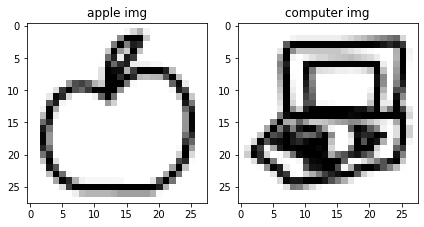

In [12]:
axes = []
fig=plt.figure()
# real
axes.append(fig.add_subplot(1, 2, 1))
subplot_title=('apple img')
axes[-1].set_title(subplot_title)
plt.imshow(apple[100, :, :, 0], cmap='Greys')
# falsa
axes.append(fig.add_subplot(1, 2, 2))
subplot_title=('computer img')
axes[-1].set_title(subplot_title)
plt.imshow(compt[100, :, :, 0], cmap='Greys')

fig.tight_layout()
plt.show()

In [13]:
data = np.concatenate((apple, compt))
data.shape

(268607, 28, 28, 1)

## **Red Adversarial**

In [14]:
class GANNetwork:
  def __init__(self, data, z_dim, filename):
    # parametros para la red GAN
    self._data  = data
    self._z_dim = z_dim
    self._filename = filename
    self._img_w, self._img_h = self._data.shape[1:3]

    # instanciamos y compilamos nuestra red discriminadora
    self.discriminator = self._discriminatorBuilder()
    # instanciamos nuestra red generadora
    self.generator = self._generatorBuilder(z_dim=self._z_dim)
    # instanciamos y compilamos nuestra red adversarial
    self.adversarial = self._adversarialBuilder(z_dim=self._z_dim)


  def _discriminatorBuilder(self, depth=64, p=0.4):
      # definir los inputs
      inputs = Input((self._img_w, self._img_h, 1))
      # definir las capas onvolutionales
      conv1 = Conv2D(depth * 1, 5, strides=2, padding='same', activation='relu')(inputs)
      conv1 = Dropout(p)(conv1)
      conv2 = Conv2D(depth * 2, 5, strides=2, padding='same', activation='relu')(conv1)
      conv2 = Dropout(p)(conv2)
      conv3 = Conv2D(depth * 4, 5, strides=2, padding='same', activation='relu')(conv2)
      conv3 = Dropout(p)(conv3)
      conv4 = Conv2D(depth * 8, 5, strides=1, padding='same', activation='relu')(conv3)
      conv4 = Flatten()(Dropout(p)(conv4))
      # capa de salida
      output = Dense(1, activation='sigmoid')(conv4)
      # definir y compilar el modelo
      model = Model(name='Discriminator', inputs=inputs, outputs=output)
      model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                    metrics=['accuracy'])
      
      return model

      
  def _generatorBuilder(self, z_dim=32, depth=64, p=0.4):
      # definir los inputs
      inputs = Input((z_dim,))
      # primer capa densa
      dense1 = Dense(7 * 7 * 64)(inputs)
      dense1 = BatchNormalization(momentum=0.9)(dense1)  # default momentum for moving average is 0.99
      dense1 = Activation(activation='relu')(dense1)
      dense1 = Reshape((7, 7, 64))(dense1)
      dense1 = Dropout(p)(dense1)
      # capas deconvolutionales
      conv1 = UpSampling2D()(dense1)
      conv1 = Conv2DTranspose(int(depth / 2), kernel_size=5, padding='same', activation=None,)(conv1)
      conv1 = BatchNormalization(momentum=0.9)(conv1)
      conv1 = Activation(activation='relu')(conv1)
      # conv 2
      conv2 = UpSampling2D()(conv1)
      conv2 = Conv2DTranspose(int(depth / 4), kernel_size=5, padding='same', activation=None,)(conv2)
      conv2 = BatchNormalization(momentum=0.9)(conv2)
      conv2 = Activation(activation='relu')(conv2)
      # conv 3
      conv3 = Conv2DTranspose(int(depth / 8), kernel_size=5, padding='same', activation=None,)(conv2)
      conv3 = BatchNormalization(momentum=0.9)(conv3)
      conv3 = Activation(activation='relu')(conv3)
      # capa de salida
      output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
      # definir el modelo y observar el summary
      model = Model(name='Generator', inputs=inputs, outputs=output)

      return model


  def _adversarialBuilder(self, z_dim=32):
      model = Sequential(name='Adversarial')
      # Hacer pesos en la red discriminadora no entrenables
      self.discriminator.trainable = False
      # las redes generadora y discriminadora en cascada
      model.add(self.generator)
      model.add(self.discriminator)
      # compilamos la red adversarial
      model.compile(loss='binary_crossentropy',
                    optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                    metrics=['accuracy'])
      
      return model


  def generateRealImgs(self, data, batch=128):
      # muestrear imagenes reales
      realImgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch, 28, 28, 1))
      # generar los targets para las imagenes reales (1)
      realTrgs = np.ones((batch, 1))

      return realImgs, realTrgs


  def generateLatentSpace(self, z_dim=32, batch=128):
      # generamos el espacio latente
      return np.random.uniform(-1.0, 1.0, size=[batch, z_dim])


  def generateFakeImgs(self, z_dim=32, batch=128):
      # generamos el espacio latente
      X = self.generateLatentSpace(z_dim=self._z_dim, batch=batch)
      # generar imagenes falsas
      fakeImgs = self.generator.predict(X)
      # generar los targets para las imagenes falsas (0)
      fakeTrgs = np.zeros((batch, 1))

      return fakeImgs, fakeTrgs 


  def train(self, epochs=2000, z_dim=32, batch=128, instances=8, save=False):
    # guardaremos las métricas de desempeño tanto de la red adversarial
    # como de la red discriminadora
    advrMetrics = []
    discMetrics = []
    
    # particionamos el batch para reales y falsas
    halfBatch = int(batch/2)

    for epoch in range(epochs):
        # (1) ENTRENAMIENTO DE LA RED DISCRIMINADORA
        realX, realY = self.generateRealImgs(data=self._data, batch=halfBatch)
        fakeX, fakeY = self.generateFakeImgs(z_dim=self._z_dim, batch=halfBatch)
        # creando una solo dataset
        X = np.concatenate((realX, fakeX))
        y = np.concatenate((realY, fakeY))
        # entrenar la red
        discMetrics.append(self.discriminator.train_on_batch(X, y))

        # (2) ENTRENAMIENTO DE LA RED GAN
        # generamos el espacio latente
        X = self.generateLatentSpace(z_dim=self._z_dim, batch=batch)
        # creamos etiquetas invertidas para las muestras falsas
        y = np.ones([batch, 1])
        # entrenar la red
        advrMetrics.append(self.adversarial.train_on_batch(X, y))
        
        # mostramos el progreso del entrenamiento y las imagenes que se van generando
        if (epoch + 1) % 100 == 0:
            print('epoch #{}'.format(epoch + 1))
            # generamos imagenes a partir de un espacio latente con
            # un numero determinado de instancias
            imgs = self.generator.predict(self.generateLatentSpace(z_dim=self._z_dim, batch=instances))
            # dibujamos las imagenes
            plt.figure(figsize=(5, 5))
            for k in range(imgs.shape[0]):
                plt.subplot(1, instances,  k + 1)
                plt.imshow(imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
        
    # guaramos los pesos de la red generadora
    if save:
        self.generator.save(self._filename)


    return advrMetrics, discMetrics

In [15]:
gan = GANNetwork(data=data, z_dim=32, filename='generator_model_2imgs.h5')

In [16]:
gan.discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)       

In [17]:
gan.generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0 

In [18]:
gan.adversarial.summary()

Model: "Adversarial"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Functional)       (None, 28, 28, 1)         183713    
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 4311553   
Total params: 4,495,266
Trainable params: 177,329
Non-trainable params: 4,317,937
_________________________________________________________________


In [20]:
# almacenar las métricas de desempeño en caso de correr el algoritmo más de una vez
advrMetrics = []
discMetrics = []

epoch #100


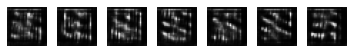

epoch #200


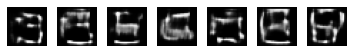

epoch #300


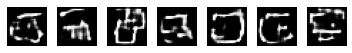

epoch #400


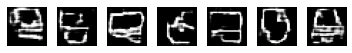

epoch #500


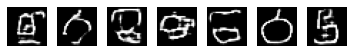

epoch #600


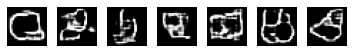

epoch #700


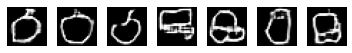

epoch #800


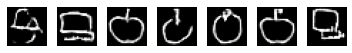

epoch #900


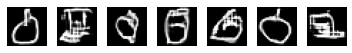

epoch #1000


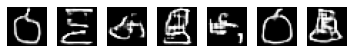

epoch #1100


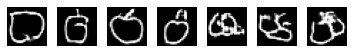

epoch #1200


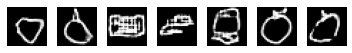

epoch #1300


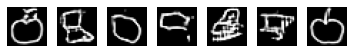

epoch #1400


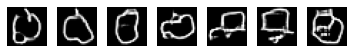

epoch #1500


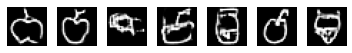

epoch #1600


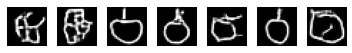

epoch #1700


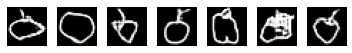

epoch #1800


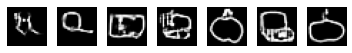

epoch #1900


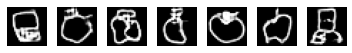

epoch #2000


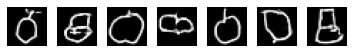

In [21]:
# ejecutamos el algoritmo
aMetrics, dMetrics = gan.train(epochs=2000, instances=7, save=True)
# acumulamos las métricas de desempeño
advrMetrics += aMetrics
discMetrics += dMetrics

##### **Métricas del desempeño de las redes**

[]

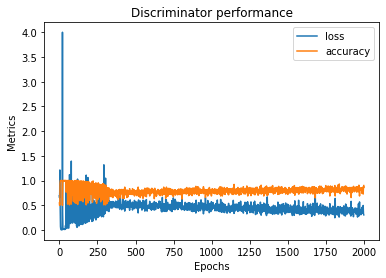

In [22]:
# mostrando el loss de la red discriminadora
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in discMetrics],
    'accuracy': [metric[1] for metric in discMetrics],
  }
).plot(title='Discriminator performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()

[]

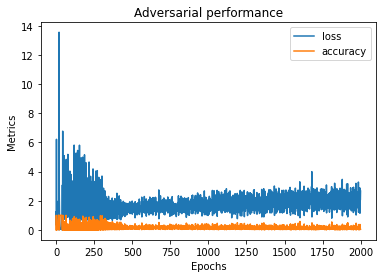

In [23]:
# mostrando el loss de la red adversarial
ax = pd.DataFrame({
    'loss':     [metric[0] for metric in advrMetrics],
    'accuracy': [metric[1] for metric in advrMetrics],
  }
).plot(title='Adversarial performance')

ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.plot()